In [88]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt



class PadPrompter(nn.Module):
    def __init__(self):
        super(PadPrompter, self).__init__()

        self.pad_size = 10
        self.w = 84

        self.base_size = self.w - self.pad_size * 2
        self.pad_dict = nn.ParameterDict()

        self.build_network()

    def build_network(self):

        self.pad_dict['pad_up'] = nn.Parameter(torch.empty([3, self.pad_size, self.w]))
        self.pad_dict['pad_down'] = nn.Parameter(torch.empty([3, self.pad_size, self.w]))
        self.pad_dict['pad_left'] = nn.Parameter(torch.empty([3, self.w - self.pad_size * 2, self.pad_size]))
        self.pad_dict['pad_right'] = nn.Parameter(torch.empty([3, self.w - self.pad_size * 2, self.pad_size]))

        # for name, param in self.named_parameters():
        #     print("param.shape == ", param.shape)

        # 추가하면 안됨
        # for name, param in self.named_parameters():
        #     print("build_network == ", name)
        #     nn.init.xavier_uniform_(param)

    def forward(self, x, params=None):

        # print("x.shape == ", x.shape)

        if params is not None:

            param_dict = extract_top_level_dict(current_dict=params)
            pad_up = param_dict['pad_up']
            pad_down = param_dict['pad_down']
            pad_left = param_dict['pad_left']
            pad_right = param_dict['pad_right']


        base = torch.zeros(1, 3, self.base_size, self.base_size)
        prompt = torch.cat([pad_left, base, pad_right], dim=3)
        prompt = torch.cat([pad_up, prompt, pad_down], dim=2)
        prompt = torch.cat(x.size(0) * [prompt])


        return x + prompt
                            
                            
def refine_classname(class_names):
    for i, class_name in enumerate(class_names):
        class_names[i] = class_name.lower().replace('_', ' ').replace('-', ' ')
    return class_names


def get_inner_loop_parameter_dict(params):

    param_dict = dict()

    for name, param in params:
        if param.requires_grad:
            if "norm_layer" not in name:
                param_dict[name] = param

    return param_dict


def extract_top_level_dict(current_dict):
    """
    Builds a graph dictionary from the passed depth_keys, value pair. Useful for dynamically passing external params
    :param depth_keys: A list of strings making up the name of a variable. Used to make a graph for that params tree.
    :param value: Param value
    :param key_exists: If none then assume new dict, else load existing dict and add new key->value pairs to it.
    :return: A dictionary graph of the params already added to the graph.
    """

    # print("current_dict == ", current_dict)

    output_dict = dict()
    for key in current_dict.keys():
        name = key.replace("layer_dict.", "")
        name = name.replace("layer_dict.", "")
        name = name.replace("block_dict.", "")
        name = name.replace("pad_dict.", "")
        name = name.replace("module-", "")

        # print("extract_top_level_dict  name == ", name)

        top_level = name.split(".")[0]
        sub_level = ".".join(name.split(".")[1:])

        if top_level not in output_dict:
            if sub_level == "":
                output_dict[top_level] = current_dict[key]
            else:
                output_dict[top_level] = {sub_level: current_dict[key]}
        else:
            new_item = {key: value for key, value in output_dict[top_level].items()}
            new_item[sub_level] = current_dict[key]
            output_dict[top_level] = new_item

    # print("extract_top_level_dict === ", current_dict.keys(), output_dict.keys())

    # current_dict = {"layer_dict.step3.linear1.weights'" : 1, 'layer_dict.step3.linear1.bias': 2}
    # output_dict = {'step3': {"linear1.weights'": 1, 'linear1.bias': 2}}
    # step1, step2.. 등등으로 나누는데.. 이걸 왜 하는 걸까..?

    return output_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
prompt = PadPrompter()

preprocess = transforms.Compose([
    transforms.Resize(84),
    transforms.ToTensor()
])

train_dataset = CIFAR100("./data", transform=preprocess,
                          download=True, train=True)

val_dataset = CIFAR100("./data", transform=preprocess,
                        download=True, train=False)

train_loader = DataLoader(train_dataset,
                          batch_size=25, pin_memory=True,
                          num_workers=16, shuffle=True)

class_names = train_dataset.classes
class_names = refine_classname(class_names)
indices = list(range(len(class_names)))

Files already downloaded and verified
Files already downloaded and verified


In [90]:
images, target = next(iter(train_loader))

In [91]:
names_prompt_weights_copy = get_inner_loop_parameter_dict(prompt.named_parameters())


print(names_prompt_weights_copy.keys())
print(names_prompt_weights_copy['pad_dict.pad_up'].shape)

names_prompt_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [1] + [1 for i in range(len(value.shape))]) for
                name, value in names_prompt_weights_copy.items()}



print(print(names_prompt_weights_copy.keys()))

print(names_prompt_weights_copy['pad_dict.pad_up'].shape)

# for key, value in enumerate(names_prompt_weights_copy):
#     print("key == ", key)
#     print("value shape == ", value.shape)

dict_keys(['pad_dict.pad_up', 'pad_dict.pad_down', 'pad_dict.pad_left', 'pad_dict.pad_right'])
torch.Size([3, 10, 84])
dict_keys(['pad_dict.pad_up', 'pad_dict.pad_down', 'pad_dict.pad_left', 'pad_dict.pad_right'])
None
torch.Size([1, 3, 10, 84])


In [92]:
loss = torch.tensor(1.9680).requires_grad_()

grads = torch.autograd.grad(loss, names_prompt_weights_copy.values(),create_graph=True, allow_unused=True)

grads

(None, None, None, None)

In [93]:
# X = torch.rand(25, 3, 84, 84, requires_grad=False)
# y = torch.randint(0, 5, (25,), dtype=torch.long)


# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16 * 84 * 84, 5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

    
model = CNN()

for name, param in model.named_parameters():
    if param.requires_grad:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()

prompted_images = prompt.forward(x=images, params=names_prompt_weights_copy)
outputs = model.forward(prompted_images)
loss= F.cross_entropy(outputs, y)

#grads = torch.autograd.grad(loss, names_prompt_weights_copy.values(),create_graph=True, allow_unused=True)
grads = torch.autograd.grad(loss, prompt.parameters(),create_graph=True, allow_unused=True)
grads

(tensor([[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SqueezeBackward1>),
 tensor([[[nan, nan, nan,  ..., nan, nan, nan],
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


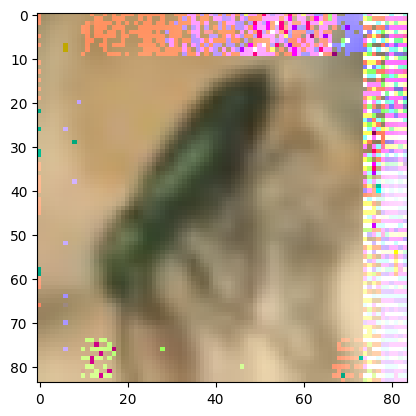

In [94]:
numpy_data = prompted_images[0].detach().numpy()

plt.imshow(numpy_data.T, cmap="gray")
plt.show()